In [84]:
from openai import OpenAI
import json
import pandas as pd
from tqdm import tqdm
import yfinance as yf
import pandas_market_calendars as mcal
import datetime
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import expected_returns
from pypfopt import plotting
from pypfopt import risk_models
import numpy as np
import matplotlib.pyplot as plt
import json
from typing import List
from openai import OpenAI
import os
import re
import pandas as pd
from tqdm import tqdm
import yfinance as yf
from gurobipy import Model, GRB, quicksum
import warnings
from dotenv import load_dotenv
import matplotlib.colors as mcolors
from IPython.display import display
import statistics

load_dotenv()

tickers = [
    'NVDA', 'AMD', 'MSFT', 'AAPL', 'INTC', 'PLTR',  # Technology
    'TSLA', 'AMZN', 'SBUX', 'TGT', 'NFLX', 'MCD',  # Consumer Discretionary
    'HOOD', 'BAC', 'JPM', 'MS', 'V', 'SCHW',  # Financials
    'ZG', 'PLD', 'WELL', 'SPG', 'PSA', 'EQR',  # Real Estate
    'GEV', 'XOM', 'DUK', 'NEE', 'EOG', 'SLB',  # Energy
    'TEM', 'UNH', 'PFE', 'MRNA', 'ABBV', 'MDT',  # Healthcare
    'CAT', 'BA', 'LMT', 'DE', 'GD', 'HON',  # Industrials
    'PCT', 'NEM', 'LIN', 'APD', 'FCX', 'MLM',  # Materials
    'GOOG', 'TMUS', 'META', 'DIS', 'VZ', 'CMCSA',  # Communication Services
    'COST', 'PEP', 'WMT', 'KO', 'PG', 'MO'  # Consumer Staples
]

warnings.filterwarnings('ignore')

pd.set_option('display.expand_frame_repr', False)  # Prevent splitting
pd.set_option('display.max_columns', None)        # Show all columns
pd.set_option('display.max_rows', None)           # Optional: Show all rows

stock_data_path = f"assets/stock_data.json"

In [85]:
models = ["4o-mini", "4o", "o1-mini"]
weight_categories = ['coord', 'coord_sparse', 'llm', 'llm_sparse', 'opt']
verbose = False

In [86]:
def save_data(data, file_path=stock_data_path):
    """
    Saves the dictionary 'data' to a JSON file at 'file_path'.
    """
    with open(file_path, 'w') as fp:
        json.dump(data, fp, indent=4)
    print(f"Data saved to {file_path}")

def load_data(file_path=stock_data_path):
    """
    Loads JSON data from 'file_path' and returns it as a dictionary.
    """
    with open(file_path, 'r') as fp:
        data = json.load(fp)
    print(f"Data loaded from {file_path}")
    return data

In [87]:
data_loaded = load_data()

Data loaded from assets/stock_data.json


In [88]:
class CoordinationFramework():
    def __init__(self, mu, Q, target_return, penalty=1, iteration=2, verbose=False):
        """
        Initialization of the class for coordination framework
        :param np.array mu: expected return of the stocks
        :param np.array Q: covariance matrix of the stocks
        :param float target_return: target return of the portfolio
        :param float penalty: penalty term in coordination algorithm
        :param float iteration: number of iteration of coordination algorithm
        """
        # Store the init params so we can restore them later
        self._init_mu = mu
        self._init_Q = Q
        self._init_target_return = target_return
        self._init_penalty = penalty
        self._init_iteration = iteration
        self._init_verbose = verbose

        # Now do the usual initialization
        self.mu = mu  # expected return
        self.Q = Q.to_numpy()  # covariance matrix
        self.n = len(mu)  # number of stocks
        self.target_return = target_return

        self.penalty = penalty
        self.iteration = iteration
        self.verbose = verbose

        # initialization
        self.current_plan = [0.0] * self.n
        self.optimization_plan = [0.0] * self.n
        self.LLM_plan = [0.0] * self.n
        self.optimization_price = [0.0] * self.n
        self.LLM_price = [0.0] * self.n

        self.feedback_factor = 0.1

        self.plan_histories = []
        self.conversation_history = []
        self.conversation_summaries = []

    def reset_variables(self):
        """
        Reset all variables to their initial values, exactly as they were in __init__.
        """
        # Restore parameters
        self.mu = self._init_mu
        self.Q = self._init_Q.to_numpy()  
        self.n = len(self._init_mu)
        self.target_return = self._init_target_return

        self.penalty = self._init_penalty
        self.iteration = self._init_iteration
        self.verbose = self._init_verbose

        # Reinitialize mutable state variables
        self.current_plan = [0.0] * self.n
        self.optimization_plan = [0.0] * self.n
        self.LLM_plan = [0.0] * self.n
        self.optimization_price = [0.0] * self.n
        self.LLM_price = [0.0] * self.n

        self.feedback_factor = 0.1

        self.plan_histories = []
        self.conversation_history = []
        self.conversation_summaries = []

    # In this function, the optimization model will update their preferred portfolio weights.
    def PortfolioOptimization_Agent(self, current_plan, verbose=False):
        # Initialize model
        self.model = Model("mean_variance_optimization")
        self.model.setParam('OutputFlag', 0)

        # Add variables (portfolio weights)
        x = {}
        for i in range(self.n):
            x[i] = self.model.addVar(vtype=GRB.CONTINUOUS, name=f"x_{i}")

        # Define terms for objective
        # ------------------------------------------------
        # Risk term = sum_{i,j} Q[i,j] * x[i] * x[j]
        risk_expr = quicksum(self.Q[i, j] * x[i] * x[j]
                            for i in range(self.n)
                            for j in range(self.n))

        # Dual (price) term = sum_{i} optimization_price[i] * x[i]
        dual_expr = quicksum(
            self.optimization_price[i] * x[i] for i in range(self.n))

        # Penalty term = penalty * sum_{i} (x[i] - current_plan[i])^2
        penalty_expr = quicksum((x[i] - current_plan[i]) * (x[i] - current_plan[i])
                                for i in range(self.n))

        # Set the model objective as:
        #   0.5 * (risk_expr) + dual_expr + 0.5 * penalty * (penalty_expr)
        self.model.setObjective(
            0.5 * risk_expr + dual_expr + 0.5 * self.penalty * penalty_expr,
            GRB.MINIMIZE
        )
        # ------------------------------------------------

        # Constraints
        # ------------------------------------------------
        # 1) Sum of weights = 1
        self.model.addConstr(quicksum(x[i] for i in range(self.n)) == 1, "budget")

        # 2) Enforce minimum target return
        self.model.addConstr(
            quicksum(self.mu[i] * x[i]
                    for i in range(self.n)) >= self.target_return,
            "target_return"
        )
        # ------------------------------------------------

        # Optimize
        self.model.optimize()

        if verbose:
            print("\n[DEBUG] Building model with:")
            print(f"[DEBUG]   mu: {self.mu}")
            print(f"[DEBUG]   Q: {self.Q}")
            print(f"[DEBUG]   target_return: {self.target_return}")
            print("[DEBUG]   current_plan:", current_plan)
            print("[DEBUG]   optimization_price:", self.optimization_price)
            print("[DEBUG]   penalty:", self.penalty)
            print("[DEBUG]   n:", self.n)
            self.model.write("debug/debug_model.lp")

            status = self.model.status
            print(f"[DEBUG] Gurobi optimization status: {status}")

        # Extract optimized weights
        weights = [x[i].x for i in range(self.n)]

        return weights


    def response_format(self):
        prompt = "please write your final recommendation in a single line, in the format below:\n\n"

        # Construct the label format dynamically based on the number of tickers.
        # Example of final output:  "AAPL: X1, MSFT: X2, AMZN: X3. Replace X1, X2, X3..."
        prompt += ", ".join([f"{ticker}: X{i+1}" for i, ticker in enumerate(tickers)])
        prompt += (
            ".\n\nReplace "
        )

        # Remind the model to replace placeholders with the actual confidence levels.
        prompt += ", ".join([f"X{i+1}" for i in range(len(tickers))])
        prompt += (
            " with the confidence level for each stock."
        )

        return prompt

    # In this function, the language model take the prompt as input and generate the preferred portfolio weights.
    def LLM_Agent(self, month_data, consensus_plan, month, iter, sparse, pure=False, verbose=False):
        system_prompt = """You are collaborating with an optimization model to develop an optimal portfolio strategy. The optimization model is an expert in numerical calculations and historical trend analysis, ensuring precision in minimizing risk and achieving target returns. Your role is to bring contextual understanding, strategic insights, and adaptability to the process.\nWhile you are encouraged to bring your unique perspective, remember:\n1. The optimization model has consistently outperformed by a significant margin (10-20%). Therefore, where substantial differences arise, you must carefully review the optimizer's proposal and adjust your recommendations unless you have a strong, data-backed reason to maintain your position.\n2. In this collaboration, flexibility and compromise are critical. Adapt your strategy when the optimizer provides strong evidence, as rigid decision-making has been shown to lead to suboptimal results.\n3. Your goal is to work synergistically with the optimizer to maximize overall portfolio performance. This requires understanding and integrating the optimizer's proposals to improve alignment.\n4. If you disagree, explicitly identify the key aspects of the optimizer's proposal that you are willing to accept or adjust. Never reject the optimizer's strategy outright—focus on making incremental refinements."""
        if pure:
            system_prompt = "You're a very advanced stock trading expert with a deep understanding in the politics, economics, and business of companies in relation to their stock performance. When you see a news, you will know whether or not it will have a strong impact on your trader planning the next move of investment decisions. You always maximize the profit through your stock investments."

        if "o1-mini" in llm_model:
            messages = []
            current_prompt = system_prompt + "\n"
        elif "o1" in llm_model:
            messages = [
                {"role": "developer", "content": system_prompt}
            ]
        else:
            messages = [
                {"role": "system", "content": system_prompt},
            ]
        messages.extend(self.conversation_history)

        # ------------------------------------------------------------------------------
        # ------------------------------------------------------------------------------
        current_prompt = ""

        if iter == 0:
            # Optionally include any initial stock info if this is the very first iteration.
            current_prompt += (
                f"{initial_stock_info}\n\n"
            )

        # summarize conversations for previous months
        # for 60 stocks, exceeds 128k tokens
        # if month != 0 and len(self.conversation_summaries) != 0:
        #     current_prompt += "Here is what happened in the last few months for you to gain a background understanding of what happened:\n"
        #     current_prompt += "\n".join(self.conversation_summaries)
        #     current_prompt += "\n\n"

        if iter == 0:
            stock_prices = f"The stock prices today are:\n"
            for i, ticker in enumerate(tickers):
                ticker_close = month_data[ticker]['price']
                stock_prices += f"{ticker} = {ticker_close}"
                if i != len(tickers) - 1:
                    stock_prices += ", "
            stock_prices += "\n"

            stock_news = ""
            for ticker in tickers:
                ticker_news = month_data[ticker]['news']
                stock_news += f"news for {ticker}:\n{ticker_news}\n\n"

            # If this is the first iteration in a given month, include relevant news and price info.
            current_prompt += (
                "Please read the following information carefully.\n\n"
                f"---\n**Stock News**\n\n{stock_news}\n\n"
                f"---\n**Recent Stock Prices**\n\n{stock_prices}\n\n"
            )

        # Begin the main decision instructions.
        current_prompt += (
            "You are a trader responsible for making portfolio allocation decisions. "
            # "Use all relevant information provided (such as any past decisions, news, or stock data) to "
            "Use all relevant information provided (such as news and stock data) to "
            "decide how much to invest in each stock.\n\n"
            "Think about:\n"
            "1. Any news articles and how they might affect each stock.\n"
            # "2. Any patterns in recent price movements.\n"
            "2. Previous decisions you have made regarding portfolio weights.\n"
        )

        # If we're past the first iteration, include guidance about consensus plans.
        if iter != 0 and self.current_plan != [0.0] * self.n and not pure:
            current_prompt += (
                "Also, you are working with a optimization model that is very proficient in numerical calculations, and here is the current plan (portfolio allocation) you guys have worked" "out. Decided if you agree with this plan, then make the necessary adjustments to your own plan: "
                f"{self.current_plan}\n\n"
            )

        current_prompt += (
            f"Also, here is the decision-price of your plan thus far: {self.LLM_price}."
            "A higher decision-price means you should adjust your plan to be higher. And a negative decision-price means you should adjust your plan to be smaller."
        )

        # Ask the model for a recommendation. Emphasize the requirement to explain reasoning first, then provide the format.
        current_prompt += (
            "### Task\n"
            "1. Carefully evaluate the optimizer's proposed portfolio weights and explain your reasoning for agreement or disagreement. When in doubt, lean towards collaboration by adjusting your recommendations closer to the optimizer's.\n"
            "2. Finalize your recommendation in the following format: [Ticker: Confidence Level]:\n"
            "   - Very Low Confidence\n"
            "   - Low Confidence\n"
            "   - Somewhat Low Confidence\n"
            "   - Neutral\n"
            "   - Somewhat High Confidence\n"
            "   - High Confidence\n"
            "   - Very High Confidence\n\n"
            "3. Conclude by summarizing how your proposal aligns with the optimizer's and why it contributes to achieving the collective goals.\n"
            "Even if you are unsure, you **must** provide the best decision you can based on the available information.\n\n"
            "Take a deep breath and work on this problem step-by-step.\n")
        
        if sparse:
            current_prompt += (
                "IMPORTANT: Aim for *sparsity* in your final allocation. "
                "Ideally select **only 5 to 10 stocks** to invest in (with confidence above 'Very Low'). "
                "Assign Very Low confidence to the rest (effectively zero). "
                "If you exceed 10 or go below 5 stocks rated above 'Very Low,' your proposal is invalid. "
                "Choose carefully.\n\n"
            )

        current_prompt += (    "### Response Format\n"
            "After your explanation, " + self.response_format() + ""
            "\nExplicitly end your response in that format. " 
            "So make sure you have these stocks and confidence levels clearly written out to be parsed by a regex function."
            "\nRemember, collaboration, adaptability, and performance are key to success."
        )

        
        # ------------------------------------------------------------------------------
        # ------------------------------------------------------------------------------


        if verbose:
            print(f"\n# month {month} iter {iter}")
            print(f"\nprompt: \n{current_prompt}\n")

        messages.append({"role": "user", "content": current_prompt})

        result_dict = []
        retry_messages = [m for m in messages]
        attempt = 0
        retry = True
        retry_reason = ""
        missing_tickers = set(tickers)
        result_dict = {}
        while retry:
            if attempt != 0:
                if retry_reason == "INVALID FORMAT":
                    new_message = "Sorry, I could not parse your response. Please try again with the correct specified formatting: " + self.response_format()

                    missing_tickers = set(tickers)
                elif retry_reason == "ZERO SUM":
                    new_message = "The sum of the weights for each stock cannot be 0. Please try again: " + self.response_format()
                    
                    missing_tickers = set(tickers)
                else: # "MISSING TICKER"
                    new_message = (
                        f"You missed the following tickers: {missing_tickers}.\n"
                        "**IMPORTANT**: If you are seeing this message, it means your response did not match "
                        "the required format and our system's regex could not interpret it.\n"
                        "Please carefully review and correct your response so it follows the exact format "
                        "below. Otherwise, the regex will continue to fail, and you will keep receiving this notice.\n\n"
                        "Provide the confidence levels for these tickers in the following format:\n"
                        + self.response_format()
                    )

                retry_messages.append({
                    "role": "user", 
                    "content": new_message
                })

                if verbose:
                    print(f"\n# month {month} iter {iter} {bcolors.RED}RETRY{bcolors.ENDC} because {retry_reason}") # PROMPT: \n{new_message}\n

            attempt += 1
            # Make an API call to ChatGPT with the prompt
            if "o1" in llm_model:
                response = client.chat.completions.create(
                    model=llm_model,
                    messages=retry_messages
                )
            else:
                response = client.chat.completions.create(
                    model=llm_model,
                    messages=retry_messages,
                    temperature=0
                )

            # Parse the decision from the response
            text = response.choices[0].message.content
            retry_messages.append({
                "role": "assistant",
                "content": text
            })

            if verbose:
                print(f"{bcolors.PURPLE}[DEBUG]{bcolors.ENDC}\tChat reponse: {text}")

            CONFIDENCE_LEVELS = {
                "Very High": 0.6,
                "High": 0.5,
                "Somewhat High": 0.4,
                "Neutral": 0.3,
                "Somewhat Low": 0.2,
                "Low": 0.1,
                "Very Low": 0.0
            }

            # Create regex pattern from confidence levels
            pattern = "|".join(CONFIDENCE_LEVELS.keys())

            original_missing_tickers = missing_tickers.copy()
            for stock in original_missing_tickers:
                # Use word boundary \b to ensure exact stock matches
                match = re.search(
                    fr'\b{stock}\b.*?:\s*({pattern})',
                    text,
                    re.IGNORECASE
                )

                if match:
                    confidence = match.group(1).title()
                    result_dict[stock] = CONFIDENCE_LEVELS[confidence]
                    missing_tickers.remove(stock)
                else:
                    retry = True
                    if verbose:
                        print(f"[DEBUG]\tCouldn't fetch {stock}.")

            retry = False

            if result_dict == {}:
                if verbose:
                    print(f"{bcolors.RED}[DEBUG]{bcolors.ENDC}\tInvalid format: could not find tickers, retrying.")
                retry = True
                retry_reason = "INVALID FORMAT"
                continue

            if sum(result_dict.values()) == 0:
                if verbose: 
                    print(f"{bcolors.RED}[DEBUG]{bcolors.ENDC}\tInvalid output: sum = 0")
                retry = True
                retry_reason = "ZERO SUM"
                continue

            if len(missing_tickers) != 0:
                print(f"{bcolors.RED}[DEBUG]{bcolors.ENDC}\tmissing {missing_tickers = }")
                retry = True
                retry_reason = "MISSING TICKER"
                continue

            if verbose:
                print(f"{bcolors.GREEN}[DEBUG]{bcolors.ENDC}\tfetched weights: {result_dict = }")
                retry = False

        # normalize sum to 1
        norm_factor = 1/sum(result_dict.values())
        result_dict = {k: v * norm_factor for k, v in result_dict.items()}
        result_dict = [r for r in result_dict.values()]


        self.conversation_history.append(
            {"role": "user", "content": current_prompt})
        self.conversation_history.append(
            {"role": "assistant", "content": text})

        norm_factor = 1/sum(result_dict)
        normalized_weights = [norm_factor * w for w in result_dict]

        return normalized_weights

    # update the consensus plan and activity price for the next iteration
    def update_plan(self, plan1, price1, plan2, price2):
        result = []
        # plan1 = [p for p in plan1.values()] # if using dict with tickers
        # plan2 = [p for p in plan2.values()]

        for p1, p2, pr1, pr2 in zip(plan1, plan2, price1, price2):
            average_plan = (p1 + p2) / 2
            average_price = (pr1 + pr2) / 2
            result.append(max(0, average_price / self.penalty + average_plan))
        return result

    def update_activity_price(self, current_activity_price, current_plan, new_plan):
        updated_prices = []
        
        for curr_price, curr_plan, new_plan_val in zip(current_activity_price, current_plan, new_plan):
            adjustment = self.penalty * (new_plan_val - curr_plan)
            updated_price = curr_price - adjustment
            updated_prices.append(updated_price)

        return updated_prices

    def test_convergence(self, all_llm_opt_plans):
        # if llm's plan and opt's plan do not differ by more than 5%
        try:
            plan_convergence = True
            for l in range(len(tickers)):
                if abs(all_llm_opt_plans[-1][l+len(tickers)+1] - all_llm_opt_plans[-1][l+2*len(tickers)+1]) > 1/20:
                    plan_convergence = False
                    break
            if plan_convergence:
                return True
        except Exception as e:
            print(f"Error occurred: {str(e)}")
        
        # if this iter's plan and last iter's plan do not differ by more than 0.2%
        # - weights have basically not changed in the past two iterations
        try:
            iter_convergence = True
            for i in range(1, len(all_llm_opt_plans[0])): 
                if abs(all_llm_opt_plans[-1][i] - all_llm_opt_plans[-2][i]) > 1/500:
                    iter_convergence = False
                    break
            if iter_convergence:
                return True
        except Exception as e:
            print(f"Error occurred: {str(e)}")

        return False
        
    def test_convergence_aux(self):
        max_diff = 0
        max_diff_ticker = None

        try:
            for l, ticker in enumerate(tickers):
                diff = abs(self.plan_histories[-1][l+len(tickers)+1] - self.plan_histories[-1][l+2*len(tickers)+1])
                if diff > max_diff:
                    max_diff = diff
                    max_diff_ticker = self.plan_histories[-1][0]

            # print(f"[DEBUG]\tThe max diff ticker is {max_diff_ticker} with a diff of {max_diff}")
        except Exception as e:
            print(f"[DEBUG] Error occurred: {str(e)}")
            pass


        
    def OptAlgorithm(self, data, verbose=False):
        self.reset_variables()

        for month, month_data in enumerate(data):
            prev_year = 2024 if month != 0 else 2023 
            prev_month = month if month != 0 else 12 

            prev_prev_year = prev_year if prev_month != 1 else 2023
            prev_prev_month = prev_month - 1 if prev_month != 1 else 12
            
            start_date = datetime.datetime(prev_prev_year, prev_prev_month, get_last_trading_day_of_month(prev_prev_year, prev_prev_month))
            end_date = datetime.datetime(prev_year, prev_month, get_last_trading_day_of_month(prev_year, prev_month))

            portfolio = pd.read_csv(pft_path, parse_dates=["Date"], index_col="Date")
            
            last_month_data = portfolio.loc[start_date].fillna(0)
            month_data = portfolio.loc[end_date].fillna(0)

            self.mu = expected_returns.mean_historical_return(portfolio.loc[start_date:end_date]) # capm_return / mean_historical_return
            self.Q = risk_models.CovarianceShrinkage(portfolio.loc[start_date:end_date]).ledoit_wolf().to_numpy()

            self.optimization_plan = self.PortfolioOptimization_Agent(self.current_plan, verbose)

            self.current_plan = self.optimization_plan
            self.optimization_price = self.update_activity_price(
                    self.optimization_price, self.optimization_plan, self.current_plan)
            
            self.plan_histories.append(self.optimization_plan)

        return self.plan_histories
    
    def LLMAlgorithm(self, data, sparse, verbose=False):
        self.reset_variables()

        for month, month_data in enumerate(data):

            # TODO
            # self.summarize()
            
            self.conversation_history = []

            self.LLM_plan = self.LLM_Agent(month_data, self.current_plan, month, 0, sparse, pure=True, verbose=verbose)
            
            self.current_plan = self.LLM_plan
            self.LLM_Price = self.update_plan(
                    self.optimization_plan, self.optimization_price, self.LLM_plan, self.LLM_price)
            
            self.plan_histories.append(self.LLM_plan)

        return self.plan_histories
    
    def summarize(self):
        sys_prompt = ""
        if "o1-mini" in llm_model:
            sys_prompt = "System Prompt: You're a trader planning the next move of investment decisions. You always maximize the profit through your stock investments."
            messages = []
        elif "o1" in llm_model:
            messages = [
                {
                    "role": "developer", "content": "You're a trader planning the next move of investment decisions. You always maximize the profit through your stock investments."
                }
            ]
        else:
            messages = [
                {
                    "role": "system", "content": "You're a trader planning the next move of investment decisions. You always maximize the profit through your stock investments."
                },
            ]
        messages.extend(self.conversation_history)
        messages.append({
            "role": "user",
            "content": sys_prompt+"Please summarize everything that happened in this conversation very succinctly, extracting the key pieces of information relevant to future stock assessments, as it will be used for another intelligent agent to overview what happened this month."
        })

        if "o1" in llm_model:
            response = client.chat.completions.create(
                model=llm_model,
                messages=messages
            )
        else:
            response = client.chat.completions.create(
                model=llm_model,
                messages=messages,
                temperature=0
            )


        text = response.choices[0].message.content
        self.conversation_summaries.append(text)

    def calculate_risk(self, weights):
        risks = []

        for w in weights:
            risk = 0.0
            for i in range(self.n):
                for j in range(self.n):
                    risk += self.Q[i, j] * w[i] * w[j]
            risks.append(risk)

        return risks

    # In this function, the coordination algorithm will update the preferred portfolio weights of the two agents.
    def CoordinationAlgorithm(self, data, sparse, verbose=False):
        self.reset_variables()
        
        for month, month_data in enumerate(data):

            prev_year = 2024 if month != 0 else 2023 
            prev_month = month if month != 0 else 12 
            
            start_date = datetime.datetime(prev_year, prev_month, 1)
            end_date = datetime.datetime(prev_year, prev_month, get_last_trading_day_of_month(prev_year, prev_month))

            portfolio = pd.read_csv(pft_path, parse_dates=["Date"], index_col="Date")
            portfolio = portfolio.loc[start_date:end_date]

            self.mu = expected_returns.mean_historical_return(portfolio) # capm_return / mean_historical_return
            self.Q = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf().to_numpy()

            # self.summarize()

            self.conversation_history = []

            for i in range(self.iteration):
                # optimization agent get the preferred portfolio weights
                
                self.optimization_plan = self.PortfolioOptimization_Agent(self.current_plan)
                # LLM agent get the preferred portfolio weights
                self.LLM_plan = self.LLM_Agent(month_data, self.current_plan, month, i, sparse, verbose=verbose)

                # update the plan for the next iteration
                self.current_plan = self.update_plan(
                    self.optimization_plan, self.optimization_price, self.LLM_plan, self.LLM_price)

                # Coordinator update dual variable/prices
                self.optimization_price = self.update_activity_price(
                    self.optimization_price, self.optimization_plan, self.current_plan)
                self.LLM_price = self.update_activity_price(
                    self.LLM_price, self.LLM_plan, self.current_plan)

                self.penalty = 1 - i/self.iteration

                all_llm_opt = [f"month {month} iter {i}"] + self.current_plan + \
                    self.LLM_plan + self.optimization_plan

                self.plan_histories.append(all_llm_opt)

                columns = ['status']
                categories = ['all', 'llm', 'opt']
                for c in categories:
                    for ticker in tickers:
                        columns.append(f'{c} {ticker}')

                if self.test_convergence(self.plan_histories):

                    all_llm_opt = [f"CONVERGED month {month} iter {i}"] + self.current_plan + \
                        self.LLM_plan + self.optimization_plan
                    self.plan_histories[-1] = all_llm_opt
                    df = pd.DataFrame(self.plan_histories, columns=columns)
                    if verbose:
                        print("[DEBUG]\tConverged because {} < ")
                        print(df) # display(df)
                    break

                else: 
                    # get the largest gap 
                    self.test_convergence_aux()

                df = pd.DataFrame(self.plan_histories, columns=columns)
                if verbose:
                    print("## updated weights\n```")
                    print(df) # display(df)
                    print("\n```\n")

        return self.plan_histories

In [89]:
def extract_month(x):
    m = re.search(r"month\s+(\d+)", x)
    return int(m.group(1)) if m else None

In [90]:
def get_stock_price(tickers, start_date, end_date):
    prices = yf.download(tickers, start=start_date, end=end_date)
    prices = prices["Adj Close"].dropna(how="all")
    return prices

start_date = datetime.datetime(2024, 1, 1)
end_date = datetime.datetime.today().date()

appendage = "nvda60"
pft_path = f"assets/portfolio_{appendage}.csv"

portfolio = get_stock_price(tickers, start_date, end_date)
portfolio.to_csv(pft_path, index=True)
portfolio = pd.read_csv(pft_path, parse_dates=True, index_col="Date")

S = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf()
mu = expected_returns.capm_return(portfolio)
CoordFW = CoordinationFramework(
    mu, S, 2.7, penalty=1, iteration=20, verbose=False)

[*********************100%%**********************]  60 of 60 completed


In [91]:
columns = []
categories = ['all', 'llm', 'opt']
for c in categories:
    for ticker in tickers:
        columns.append(f'{c} {ticker}')

In [92]:
def backtest(df, columns=None, weights_=None):
    i = 0
    initial_capital = 10000
    portfolio_value = initial_capital

    portfolio_history = [portfolio_value]
    # Create a DataFrame to track monthly PnL for each ticker
    monthly_pnl = pd.DataFrame(0.0, index=range(12), columns=tickers)

    while i < 11:
        # ---- 1) Get the weights for this month (end of month i) ----
        if columns:
            weights = df.loc[i, columns].tolist()
        else:
            weights = weights_[i]

        # ---- 2) Buy using these weights ----
        shares = []
        buy_prices = []
        initial_capital = portfolio_value

        for j, ticker in enumerate(tickers):
            buy_price = data_loaded[i][ticker]['price']
            buy_prices.append(buy_price)

            allocation = initial_capital * weights[j]  # portion of capital
            shares_bought = allocation / buy_price if buy_price > 0 else 0
            shares.append(shares_bought)

            # Deduct spent cash
            portfolio_value -= shares_bought * buy_price

        # ---- 3) Sell at month i+1 (end of next month), record PnL per ticker ----
        i += 1
        for j, ticker in enumerate(tickers):
            sell_price = data_loaded[i][ticker]['price']
            # PnL for this ticker in month i-1 (e.g. row 0 if i=1 now)
            pnl = shares[j] * (sell_price - buy_prices[j])
            monthly_pnl.loc[i - 1, ticker] = pnl  # store PnL

            # Update portfolio value by the proceeds of selling
            portfolio_value += shares[j] * sell_price

        portfolio_history.append(portfolio_value)

    print("Final Portfolio Value:", portfolio_value)
    # Return both the total portfolio value history and the per-ticker monthly PnL
    return portfolio_history, monthly_pnl

In [93]:
overall_returns = {}
risks_ = {}

In [94]:
for model in models:

    print(f"{model=}")

    if model == "4o-mini":
        # 4o mini
        weights_coord_path = "assets/weights_coord_nvda60_temp0_15.json"
        weights_coord_sparse_path = "assets/weights_coord_sparse_nvda60_temp0_15.json"
        weights_llm_path = "assets/weights_llm_nvda60_temp0_15.json"
        weights_llm_sparse_path = "assets/weights_llm_sparse_nvda60_temp0_15.json"
        weights_opt_path = "assets/weights_opt_nvda60_temp0_15.json"
    elif model == "4o":
        # 4o
        weights_coord_path = "assets/weights_coord_nvda60_temp0_18_4o.json"
        weights_coord_sparse_path = "assets/weights_coord_sparse_nvda60_temp0_18_4o.json"
        weights_llm_path = "assets/weights_llm_nvda60_temp0_18_4o.json"
        weights_llm_sparse_path = "assets/weights_llm_sparse_nvda60_temp0_18_4o.json"
        weights_opt_path = "assets/weights_opt_nvda60_temp0_18_4o.json"
    elif model == "o1-mini":
        # o1-mini
        weights_coord_path = "assets/weights_coord_nvda60_temp0_18_o1_mini.json"
        weights_coord_sparse_path = "assets/weights_coord_sparse_nvda60_temp0_18_o1_mini.json"
        weights_llm_path = "assets/weights_llm_nvda60_temp0_18_o1_mini.json"
        weights_llm_sparse_path = "assets/weights_llm_sparse_nvda60_temp0_18_o1_mini.json"
        weights_opt_path = "assets/weights_opt_nvda60_temp0_18_o1_mini.json"
    else:
        print("Invalid model")


    # HI

    with open(weights_opt_path, "r") as f:
        opt_histories = json.load(f)

    with open(weights_llm_path, "r") as f:
        llm_histories = json.load(f)

    with open(weights_llm_sparse_path, "r") as f:
        llm_histories_sparse = json.load(f)

    with open(weights_coord_path, "r") as f:
        coord_histories = json.load(f)
    weights_coord = [h[1:1+len(tickers)] for h in coord_histories]

    with open(weights_coord_sparse_path, "r") as f:
        coord_histories_sparse = json.load(f)
    weights_coord_sparse = [h[1:1+len(tickers)] for h in coord_histories_sparse]

    columns = ['status']
    categories = ['all', 'llm', 'opt']
    for c in categories:
        for ticker in tickers:
            columns.append(f'{c} {ticker}')

    df = pd.DataFrame(coord_histories, columns=columns)
    df_sparse = pd.DataFrame(coord_histories_sparse, columns=columns)

    pure_llm_history = [[] for _ in range(len(tickers))]
    j = -1
    pattern = r"month (\d+)"
    prev = -1

    for iter in df['status']:
        cur = int(re.search(pattern, iter).group(1))
        if cur != prev:
            j += 1
            prev = cur
        for i in range(len(tickers)):
            pure_llm_history[i].append(llm_histories[j][i])

    pure_llm_history_sparse = [[] for _ in range(len(tickers))]
    j = -1
    pattern = r"month (\d+)"
    prev = -1

    for iter in df['status']:
        cur = int(re.search(pattern, iter).group(1))
        if cur != prev:
            j += 1
            prev = cur
        for i in range(len(tickers)):
            pure_llm_history_sparse[i].append(llm_histories_sparse[j][i])

    pure_opt_history = [[] for _ in range(len(tickers))]
    j = -1
    pattern = r"month (\d+)"
    prev = -1

    for iter in df['status']:
        cur = int(re.search(pattern, iter).group(1))
        if cur != prev:
            j += 1
            prev = cur
        for i in range(len(tickers)):
            pure_opt_history[i].append(opt_histories[j][i])

    all_columns = [col for col in df.columns if "all" in col]

    df_filtered = df.copy(deep=True)
    df_filtered['month_num'] = df_filtered['status'].apply(extract_month)
    df_filtered['next_month_num'] = df_filtered['month_num'].shift(-1)
    mask = (df_filtered['month_num'] != df_filtered['next_month_num']
            ) | df_filtered['next_month_num'].isna()
    df_filtered = df_filtered[mask]

    df_filtered.set_index('status', inplace=True)

    days = []
    prev = 0

    for i, log in enumerate(df['status']):
        log = log.split()
        j = log.index("month")
        cur = log[j+1]
        if cur != prev:
            days.append(i-1)
            prev = cur

    days.append(i+1)

    df_init = df[df['status'].str.contains('iter 0')].reset_index(drop=True)
    df_end = df.iloc[[d - 1 for d in days[1:]]].reset_index(drop=True)

    df_init_sparse = df_sparse[df_sparse['status'].str.contains(
        'iter 0')].reset_index(drop=True)
    df_end_sparse = df_sparse.iloc[[
        d - 1 for d in days[1:]]].reset_index(drop=True)

    all_weights = ["all " + ticker for ticker in tickers]

    # For example, the coordinated strategy:
    portfolio_history_coordinated, pnl_coordinated = backtest(
        df_end, columns=all_weights)
    portfolio_history_coordinated_sparse, pnl_coordinated_sparse = backtest(
        df_end_sparse, columns=all_weights)

    # Or the pure OPT strategy:
    portfolio_history_opt, pnl_opt = backtest(df_init, weights_=opt_histories)

    # Or the pure LLM strategy:
    portfolio_history_llm, pnl_llm = backtest(df_init, weights_=llm_histories)
    portfolio_history_llm_sparse, pnl_llm_sparse = backtest(
        df_init_sparse, weights_=llm_histories_sparse)
    
    portfolios = [portfolio_history_coordinated, portfolio_history_coordinated_sparse, portfolio_history_opt, portfolio_history_llm, portfolio_history_llm_sparse]

    # Averaged LLM + OPT
    # portfolio_history_avg, pnl_avg = backtest(
    #     df_init, weights_=avg_opt_llm_histories)
    # portfolio_history_avg_sparse, pnl_avg_sparse = backtest(
    #     df_init_sparse, weights_=avg_opt_llm_sparse_histories)

    # return rate last month - initial value
    if verbose: print("Overall return:")
    overall_returns[model] = []
    for i, pft in enumerate(portfolios):
        ret = round((pft[-1]-pft[0])/pft[0], 4)
        if verbose: print(f'{weight_categories[i]}:\t{r:.4f}')
        overall_returns[model].append(ret)
        # print(statistics.stdev(return_rate_by_month))
    
    risks = []
    for h in [weights_coord, weights_coord_sparse, opt_histories, llm_histories, llm_histories_sparse]:
        risks.append(CoordFW.calculate_risk(h))

    # risk 
    # if verbose: print("Risk:")
    risks_[model] = []
    for i, r in enumerate(risks):
        risk = round(statistics.mean(r), 4)
        if verbose: print(f'{weight_categories[i]}:\t{risk:.4f}')
        risks_[model].append(risk)
        # print(f'{round(statistics.stdev(r), 4):.4f}')

    # if verbose: print()

model='4o-mini'


Final Portfolio Value: 14579.503331081947
Final Portfolio Value: 14641.407483913017
Final Portfolio Value: 14119.311152827317
Final Portfolio Value: 12765.811256387686
Final Portfolio Value: 13342.97507863346
model='4o'
Final Portfolio Value: 13847.35291824519
Final Portfolio Value: 15814.455116024907
Final Portfolio Value: 14053.798493681392
Final Portfolio Value: 13342.86649215922
Final Portfolio Value: 14722.566918253719
model='o1-mini'
Final Portfolio Value: 13398.846571561551
Final Portfolio Value: 11299.960100433942
Final Portfolio Value: 14119.31472514349
Final Portfolio Value: 14080.32794784334
Final Portfolio Value: 15983.008645603493


In [95]:
# overall_returns['4o'][2] = overall_returns['4o-mini'][2]
# overall_returns['o1-mini'][2] = overall_returns['4o-mini'][2]

# risks_['4o'][2] = risks_['4o-mini'][2]
# risks_['o1-mini'][2] = risks_['4o-mini'][2]


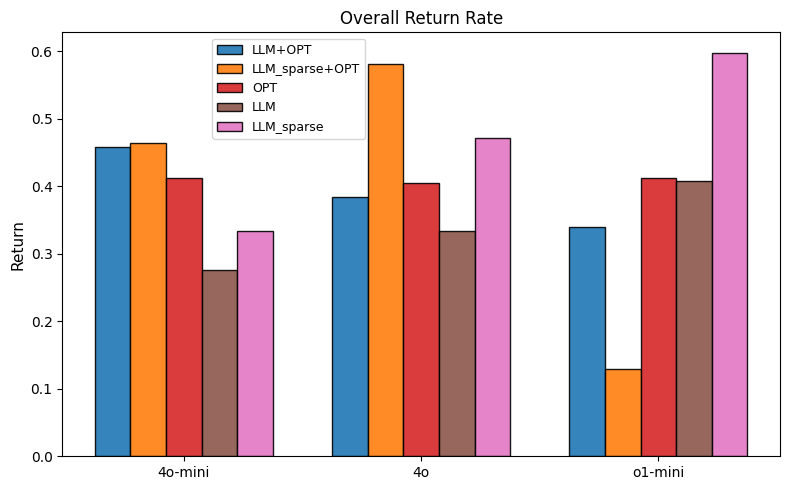

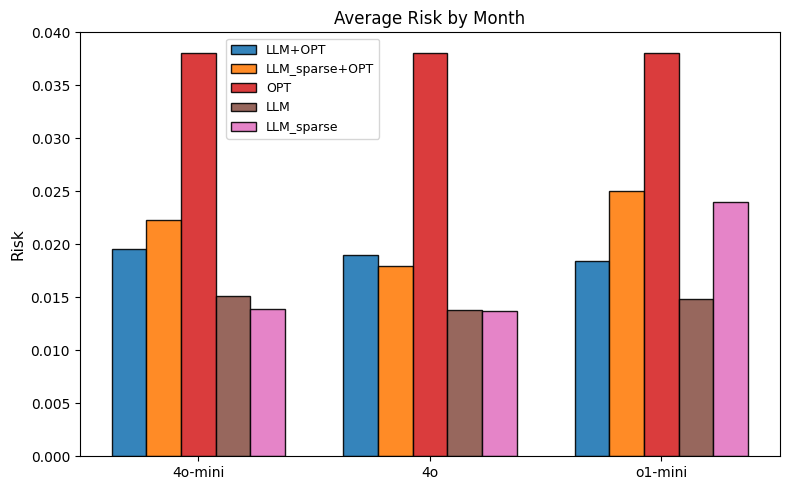

In [101]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# -----------------------------
# 1) Gather final-cell results
# -----------------------------
model_names = ["4o-mini", "4o", "o1-mini"]
# categories  = ["coord", "coord_sparse", "llm", "llm_sparse", "opt"]
categories = ["LLM+OPT", "LLM_sparse+OPT", "OPT", "LLM", "LLM_sparse"]  # Reordered opt to 3rd


# For a nice yellow→orange→red progression:
# bar_colors = ["gold", "darkorange", "orangered", "crimson", "darkred"]


def plot_grouped_bars(measure_dict, 
                      title="Overall Return", 
                      y_label="Return"):
    """
    measure_dict: dictionary keyed by model -> list of 5 values
    title: title of the plot
    y_label: label for the y-axis
    """
    x = np.arange(len(model_names))  # [0, 1, 2] for the 3 models
    width = 0.15                    # width of each bar

    num_plots = 7
    colors = cm.get_cmap('tab10', num_plots).colors

    fig, ax = plt.subplots(figsize=(8, 5))

    # We’ll place 5 bars per cluster. The offsets center them around each x.
    offsets = np.linspace(-2*width, 2*width, 5)  # 5 offsets from left to right

    bars = []  

    # Plot each of the 5 categories in each cluster
    for i, category in enumerate(categories):
        # Extract the values for (4o-mini, 4o, o1-mini) in the given category
        values = [ measure_dict[m][i] for m in model_names ]

        # Create bar positions: x + offset
        bar_positions = x + offsets[i]

        # Plot the bars
        bar = ax.bar(bar_positions, values, 
               width=width, 
               label=category, 
               color=colors[i],
               edgecolor='black', alpha=0.9)
        bars.append(bar)

    # Labeling
    ax.set_xticks(x) 
    ax.set_xticklabels(model_names, fontsize=10)
    ax.set_ylabel(y_label, fontsize=11)
    ax.set_title(title, fontsize=12)

    ax.legend(bars, categories, fontsize=9, loc="upper left", bbox_to_anchor=(.2, 1))

    plt.tight_layout()
    plt.savefig(f"figures/AAA_{'_'.join(title.split())}.png", dpi=450)
    plt.show()


# ---------------------------------
# 2) Plot Overall Return
# ---------------------------------
plot_grouped_bars(overall_returns, 
                  title="Overall Return Rate", 
                  y_label="Return")


# ---------------------------------
# 3) Plot Risk
# ---------------------------------
plot_grouped_bars(risks_, 
                  title="Average Risk by Month", 
                  y_label="Risk")